# A Simple Model

### Implement a quick and simple model which includes:
1. Seasonality
2. Holidays and Events

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# Plotting import
import matplotlib.pyplot as plt
from plotting.time_series.style import plot_params  # plot style settings

In [3]:
from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Importing Data

In [4]:
train_data = pd.read_csv(
    comp_dir / "train.csv", index_col="id", header=0, parse_dates=["date"]
)
stores_data = pd.read_csv(
    comp_dir / "stores.csv", index_col="store_nbr", header=0
)
holidays_events_data = pd.read_csv(
    comp_dir / "holidays_events.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)
oil_data = pd.read_csv(
    comp_dir / "oil.csv", index_col="date", header=0, parse_dates=["date"]
)
transactions_data = pd.read_csv(
    comp_dir / "transactions.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)

# Preparing Data

In [5]:
train_data_clean = train_data.copy()
train_data_clean["date"] = train_data.date.dt.to_period("D")

train_data_clean = train_data_clean.astype(
    {"store_nbr": "category", "family": "category", "sales": "float32"}
)
train_data_clean.drop("onpromotion", axis=1, inplace=True)
train_data_clean = train_data_clean.set_index(
    ["store_nbr", "family", "date"]
).sort_index()

In [6]:
range_begin = "2017"
range_end = "2017-08-15"
# Create Labels data (y output)
y = train_data_clean.unstack(["store_nbr", "family"]).loc[
    range_begin:range_end
]

In [7]:
# Holidays and Events
holidays_events_data = holidays_events_data.astype(
    {
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    }
)
holidays_events_data = holidays_events_data.set_index("date").to_period("D")
holidays = holidays_events_data.loc[range_begin:range_end, ["type", "locale"]]
# holidays = holidays.loc[holidays.locale.isin(["National","Regional"]) ]

# Remove duplicate
holidays = (
    holidays.reset_index()
    .drop_duplicates(subset="date", keep="last")
    .set_index("date")
)

# Building Model

In [8]:
# Creating Training Data
fourier = CalendarFourier(freq="M", order=4)  # Fourier(period=14, order=7)#
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
    period=7,
)
X = dp.in_sample()
X["NewYear"] = X.index.dayofyear == 1  # X.loc["2016-12-31":"2017-01-02"]

# Holidays and Events
X_holidays = pd.get_dummies(holidays)
X = X.join(X_holidays).fillna(0.0)

# Modeling Fitting
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

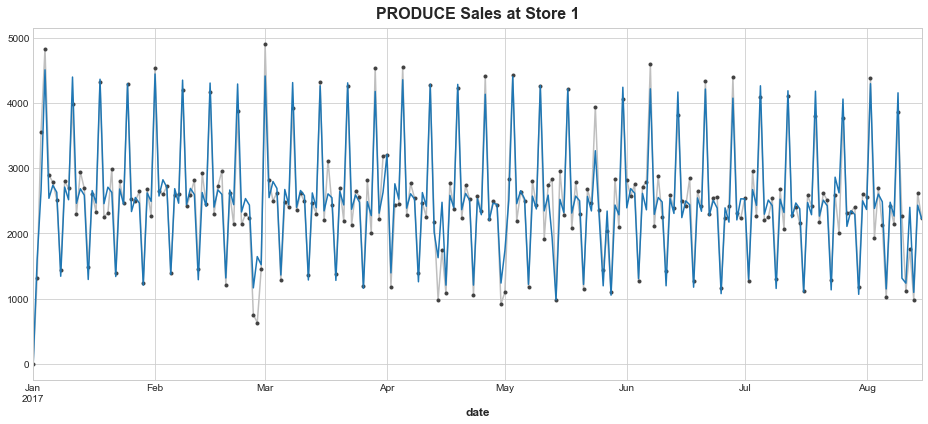

In [9]:
# Visualizing
STORE_NBR = 1  # 1 - 54
FAMILY = "PRODUCE"
# to list all FAMILY
#   display(store_sales.index.get_level_values('family').unique())

figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)
y.loc(axis=1)["sales", STORE_NBR, FAMILY].plot(**plot_params, ax=ax)
y_pred.loc(axis=1)["sales", STORE_NBR, FAMILY].plot(ax=ax)

# Another way to plot
"""ax.plot_date(
    holidays.index,
    y_pred.loc(axis=1)["sales", STORE_NBR, FAMILY].loc[holidays.index],
    color="b",
    marker="s",
)"""

ax.set_title(f"{FAMILY} Sales at Store {STORE_NBR}")
plt.show()

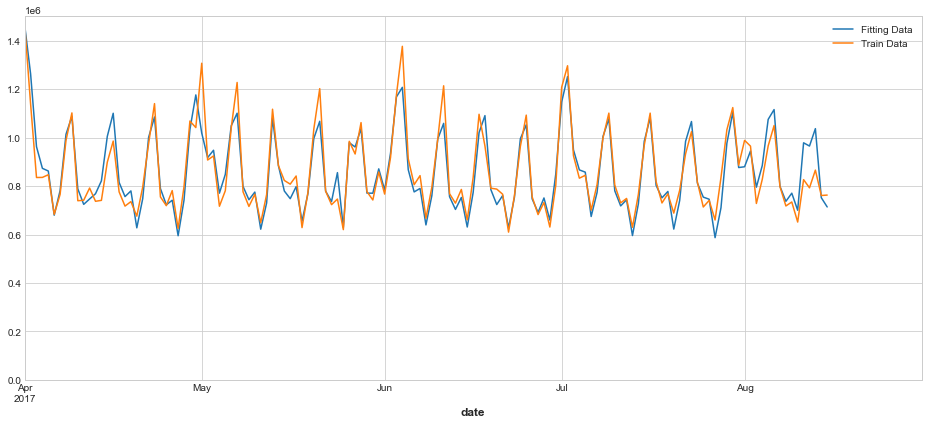

In [10]:
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)

y_pred.stack(["store_nbr", "family"]).reset_index().groupby(
    "date"
).sales.sum().plot(ax=ax)
train_data.groupby("date").agg({"sales": "sum"}).reset_index().set_index(
    "date"
).plot(ax=ax)

ax.legend(["Fitting Data", "Train Data"])
ax.set(xlim=[date(2017, 4, 1), date(2017, 8, 31)])
ax.set(ylim=[0, 1.5e6])
plt.show()

# Predict Future Sales

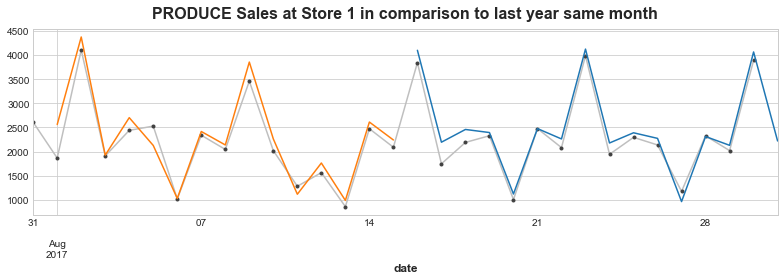

In [11]:
# Import Test Data 
df_test = pd.read_csv(
    comp_dir / "test.csv",
    parse_dates=["date"],
    infer_datetime_format=True,
)
df_test = df_test.astype(
    {"store_nbr": "category", "family": "category", "onpromotion": "uint32"}
)
df_test["date"] = df_test.date.dt.to_period("D")
df_test = df_test.set_index(["store_nbr", "family", "date"]).sort_index()

# Creating Testing Features 
X_test = dp.out_of_sample(steps=16)
X_test.index.name = "date"
X_test["NewYear"] = X_test.index.dayofyear == 1
X_test = X_test.join(X_holidays).fillna(0.0)

# Modeling Predicting 
y_pred = pd.DataFrame(
    model.predict(X_test), index=X_test.index, columns=y.columns
)
y_submit = y_pred.stack(["store_nbr", "family"]).reorder_levels(
    ["store_nbr", "family", "date"]
)
y_submit = y_submit.join(df_test.id).reindex(columns=["id", "sales"])
y_submit["sales"] = np.where(y_submit["sales"] < 0, 0, y_submit["sales"])

# Submission 
# y_submit.to_csv('submission.csv', index=False)

# Visualizing 
STORE_NBR = 1
FAMILY = "PRODUCE"
y2 = train_data_clean.unstack(["store_nbr", "family"]).loc["2016-08"]
y3 = train_data_clean.unstack(["store_nbr", "family"]).loc["2017-08"]
y2.index = y2.index + 364
ax = y2.loc(axis=1)["sales", STORE_NBR, FAMILY].plot(**plot_params)
y_pred.loc(axis=1)["sales", STORE_NBR, FAMILY].plot(ax=ax)
y3.loc(axis=1)["sales", STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(
    f"{FAMILY} Sales at Store {STORE_NBR} in comparison"
    + " to last year same month"
)
plt.show()